In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import networkx as nx
import seaborn as sns

In [5]:
output = '~/WORKS/TrueNets/Data/Italia/sociecon/'
comune = 'Pontremoli'
vdf = pd.read_csv(f'{output}/{comune.lower()}_volumes.csv',
                      dtype={'id': str, 'volume': float, 'height': float, 'area': float}
                      ).set_index('id', drop=False)

2168 1553


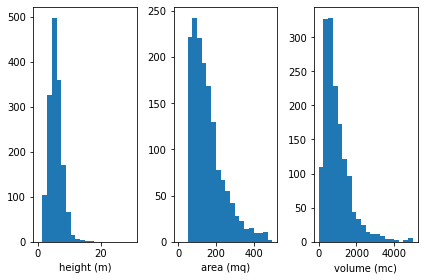

In [68]:
myvdf = vdf[(vdf.height>2) & (vdf.area>50)]
print(len(vdf), len(myvdf))
ax = plt.subplot(1,3,1)
ax.hist(myvdf.height, bins=20, range=(0,30))
ax.set_xlabel('height (m)')
ax = plt.subplot(1,3,2)
ax.hist(myvdf.area, bins=20, range=(0,500))
ax.set_xlabel('area (mq)')
ax = plt.subplot(1,3,3)
ax.hist(myvdf.volume, bins=20, range=(0,5000))
ax.set_xlabel('volume (mc)')
plt.tight_layout()

Text(0.5, 1.0, '200mc volume per household')

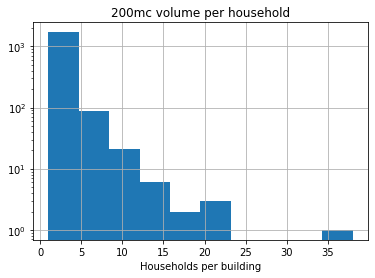

In [23]:
hdf = pd.read_csv(f'{output}/{comune.lower()}_households.csv',
                      names=('id', 'households'),
                      header=1,
                      dtype={'id': str, 'households': int}
                      ).set_index('id', drop=False)
fix, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlabel('Households per building')
hdf.households.hist(ax=ax)
plt.title('200mc volume per household')

Text(0, 0.5, 'reliability')

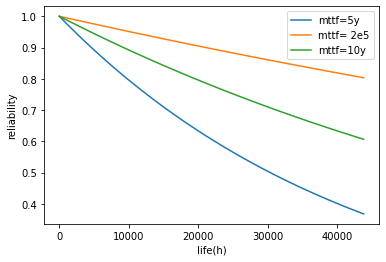

In [4]:
mttf = 5*365*24
router_rel  =  2e5 #source verbrugge 2006

x = np.linspace(0,5*365*24) #20yrs
def life(x,mttf):
    l=1/mttf
    return np.e**(-l*x)

plt.plot(x, life(x, 5*365*24), label='mttf=5y')
plt.plot(x, life(x, router_rel), label='mttf= 2e5')
plt.plot(x, life(x, 10*365*24), label='mttf=10y')
plt.legend()
plt.xlabel('life(h)')
plt.ylabel('reliability')


In [167]:
from heapq import heappop, heappush

def primdijkstra(G, root, alpha=1):
    #Implement the MST-SPT tree with alpha, mentioned in the MENTOR paper
    #alpha = 1 yields the SPT, alpha=0 yields the MST
    if root not in G.nodes():
        raise nx.NetworkXError
    T = nx.Graph()
    T.add_node(root) #Initalize Tree by adding the root
    costs = {}
    costs[root] = 0  
    while(len(T)< len(G)):
        edges = []  #Frontier 
        for n in T.nodes():
            for e in G.edges(n, data=True):  
                if e[1] not in T: #For each edges incident to the current Tree T
                    dist = alpha*costs[e[0]] + e[2]['weight']  #Compute label and push to heap
                    heappush(edges, (dist, e))
        d, e = heappop(edges) #Get minimum
        T.add_edges_from([e])  #Add to the Tree
        costs[e[1]] = costs[e[0]] + e[2]['weight']  #Push the updated weight of the tree frontier
    return T

def average_path_length(graph: nx.Graph, gw):
    gws = [gw]
    plenghts = nx.multi_source_dijkstra_path_length(graph, gws, weight=lambda s,d,w: 1)
    lengths = np.array(list(plenghts.values()))
    return lengths.mean(), lengths.max()

In [111]:
#Generate a random graph with random weights
g = nx.erdos_renyi_graph(100,0.3)
for (u,v,w) in g.edges(data=True):
    w['weight'] = random.random()
b = max(nx.closeness_centrality(g, distance='weight').items(), key=lambda x:x[1])[0]

In [168]:
results = []

for alpha in np.linspace(0,1,20):
    T = primdijkstra(g, b, alpha)
    avg_p, max_p = average_path_length(T, b)
    cost = sum([e[2]['weight'] for e in T.edges(data=True)])
    edges = len(T.edges())
    results.append({'alpha': alpha, 'cost': cost, 'avg_p': avg_p, 'max_p': max_p, 'edges': edges})

results = pd.DataFrame(results)

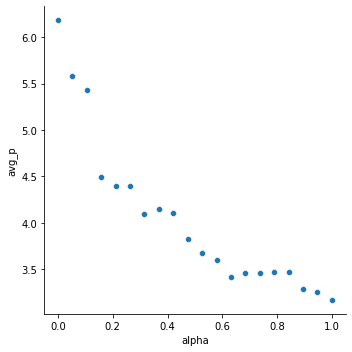

In [166]:
sns.relplot(data=results, x='alpha', y='avg_p')